<a href="https://colab.research.google.com/github/ThiviruDulanaka/ML_Def_CW/blob/main/Final_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import KNNImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [41]:
# Read Dataset
bank_data = pd.read_csv('/bank-full.csv', sep=';')

In [42]:
# Sanity Check of Data
print("\n--- First 5 Rows ---")
print(bank_data.head())


--- First 5 Rows ---
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [43]:
print("\n--- Info ---")
bank_data.info()


--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [44]:
print("\n--- Summary Statistics ---")
print(bank_data.describe(include='all'))


--- Summary Statistics ---
                 age          job  marital  education default        balance  \
count   45211.000000        45211    45211      45211   45211   45211.000000   
unique           NaN           12        3          4       2            NaN   
top              NaN  blue-collar  married  secondary      no            NaN   
freq             NaN         9732    27214      23202   44396            NaN   
mean       40.936210          NaN      NaN        NaN     NaN    1362.272058   
std        10.618762          NaN      NaN        NaN     NaN    3044.765829   
min        18.000000          NaN      NaN        NaN     NaN   -8019.000000   
25%        33.000000          NaN      NaN        NaN     NaN      72.000000   
50%        39.000000          NaN      NaN        NaN     NaN     448.000000   
75%        48.000000          NaN      NaN        NaN     NaN    1428.000000   
max        95.000000          NaN      NaN        NaN     NaN  102127.000000   

       hous

In [45]:
print("\n--- Class Distribution (Target Variable 'y') ---")
print(bank_data['y'].value_counts())


--- Class Distribution (Target Variable 'y') ---
y
no     39922
yes     5289
Name: count, dtype: int64


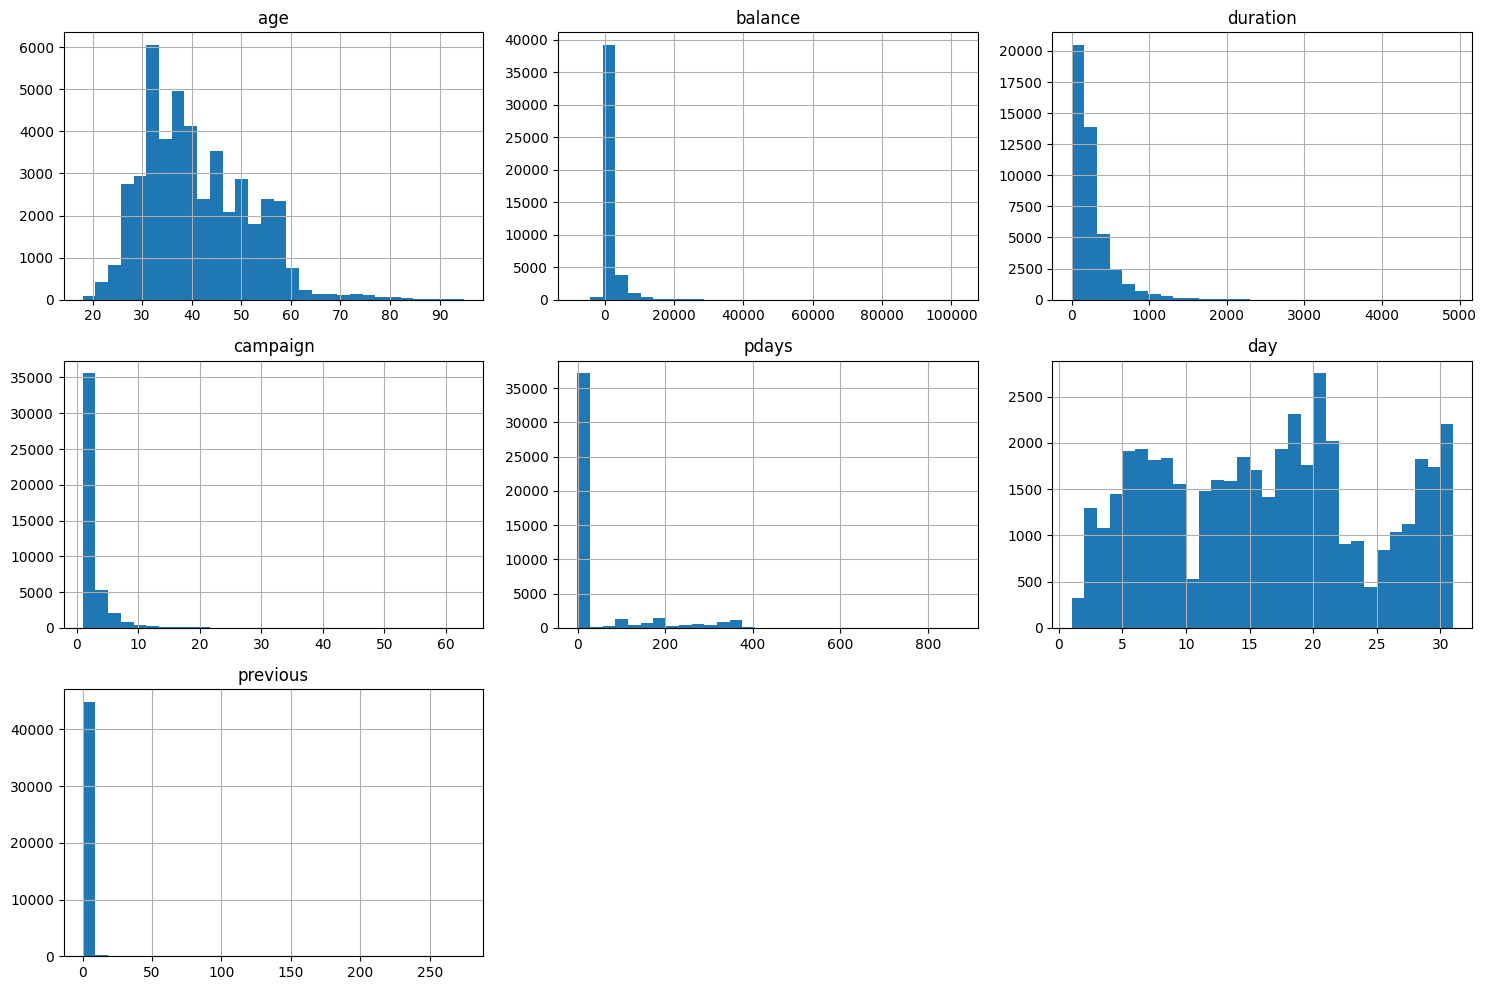

In [46]:
# Exploratory Data Analysis (EDA)
# Check distribution of numerical features
numeric_cols = ['age', 'balance', 'duration', 'campaign', 'pdays','day', 'previous']
bank_data[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


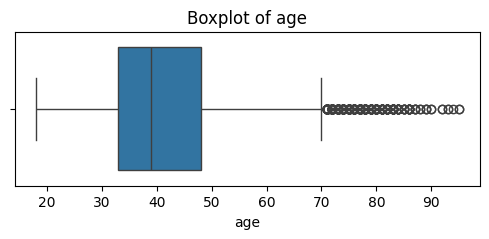

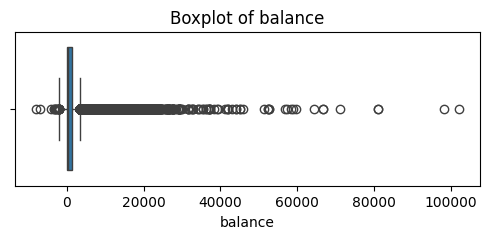

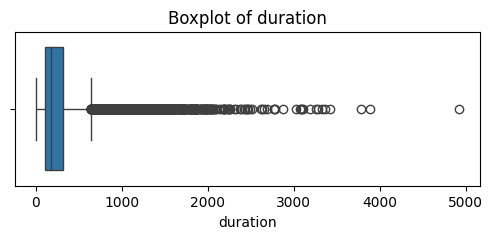

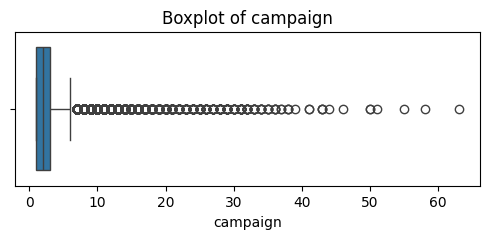

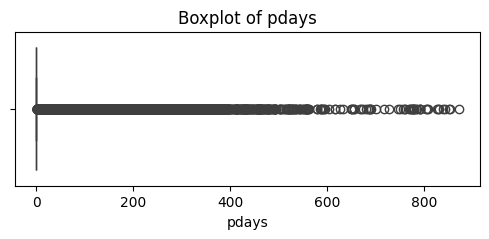

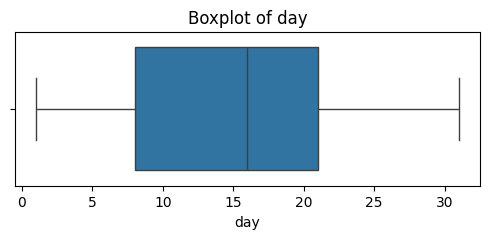

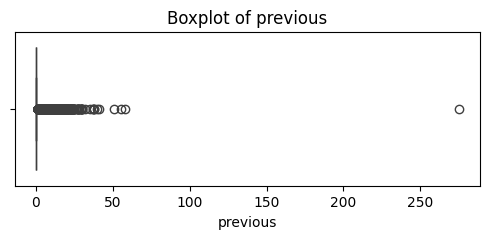

In [47]:
# Boxplots to detect outliers
for col in numeric_cols:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=bank_data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [48]:
# Missing Value Treatment
print("\n--- Checking Missing Values ---")
print(bank_data.isnull().sum())



--- Checking Missing Values ---
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [49]:
# No explicit missing values, but 'unknown' needs to be treated in categorical columns
cat_cols = bank_data.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    print(f"\n{col} - 'unknown' count: {sum(bank_data[col] == 'unknown')}")


job - 'unknown' count: 288

marital - 'unknown' count: 0

education - 'unknown' count: 1857

default - 'unknown' count: 0

housing - 'unknown' count: 0

loan - 'unknown' count: 0

contact - 'unknown' count: 13020

month - 'unknown' count: 0

poutcome - 'unknown' count: 36959

y - 'unknown' count: 0


In [50]:
# Replace 'unknown' with NaN for imputation or separate category
def handle_unknowns(df):
    for col in cat_cols:
        df[col] = df[col].replace('unknown', np.nan)
    return df

bank_data = handle_unknowns(bank_data)

In [52]:
# Outlier Treatment using IQR method for numerical features
def treat_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_whisker, lower_whisker,
                       np.where(df[col] > upper_whisker, upper_whisker, df[col]))
    return df

for col in numeric_cols:
    bank_data = treat_outliers_iqr(bank_data, col)


In [53]:
# Duplicate and Garbage Value Treatment
print("\n--- Duplicate Rows ---")
print(bank_data.duplicated().sum())


--- Duplicate Rows ---
0


In [54]:
# Normalization (MinMax Scaling)
scaler = MinMaxScaler()
bank_data[numeric_cols] = scaler.fit_transform(bank_data[numeric_cols])

In [55]:
# Encoding Categorical Variables
# For simplicity, use Label Encoding for binary vars and One-Hot for others
le = LabelEncoder()
bank_data['y'] = le.fit_transform(bank_data['y'])  # Target encoding

binary_cols = ['default', 'housing', 'loan']
for col in binary_cols:
    bank_data[col] = le.fit_transform(bank_data[col].astype(str))


In [56]:
# One-hot encoding for the rest
bank_data = pd.get_dummies(bank_data, columns=[col for col in cat_cols if col not in binary_cols + ['y']], drop_first=True)

In [57]:
# Final shape after preprocessing
print("\n--- Final Data Shape After Preprocessing ---")
print(bank_data.shape)


--- Final Data Shape After Preprocessing ---
(45211, 39)


# model training

Import Decision Tree & Evaluation Libraries

In [58]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Split the Data (Features + Target + Train-Test)

---



In [59]:


# Split features and target
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n--- Train/Test Shapes ---")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")



--- Train/Test Shapes ---
X_train: (36168, 38), X_test: (9043, 38)
y_train: (36168,), y_test: (9043,)


In [60]:
# SMOTE
from imblearn.over_sampling import SMOTE
# Apply SMOTE to only the training set
sm = SMOTE(random_state=42)
X_train_sm , y_train_sm = sm.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_sm.value_counts())




Original class distribution:
 y
0    31937
1     4231
Name: count, dtype: int64
After SMOTE:
 y
0    31937
1    31937
Name: count, dtype: int64


Train the Decision Tree Classifier

In [61]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)

# Fit the model
dt_model.fit(X_train_sm, y_train_sm)


DecisionTreeClassifier(max_depth=5, random_state=42)

Predict on Test Set and Evaluate

 Decision Tree Accuracy: 0.7888

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      7985
           1       0.33      0.81      0.47      1058

    accuracy                           0.79      9043
   macro avg       0.65      0.80      0.67      9043
weighted avg       0.90      0.79      0.82      9043



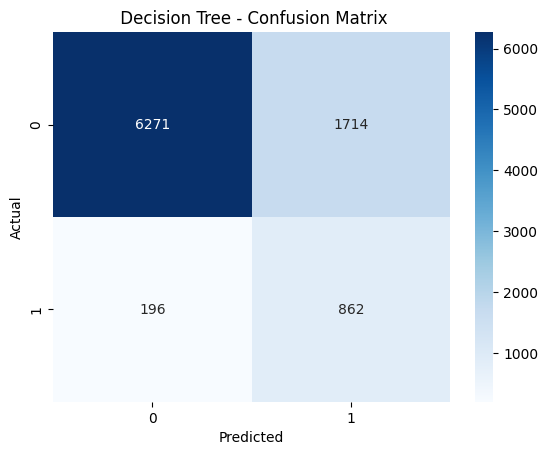

In [62]:
# Predict
y_pred_dt = dt_model.predict(X_test)

# Accuracy
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f" Decision Tree Accuracy: {dt_accuracy:.4f}")

# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(" Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [63]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_prob_dt = dt_model.predict_proba(X_test)[:, 1]
roc_auc_dt = roc_auc_score(y_test, y_pred_prob_dt)
print(f"🌳 Decision Tree ROC-AUC Score: {roc_auc_dt:.4f}")


🌳 Decision Tree ROC-AUC Score: 0.8630


🔍 Top 10 Important Features:
duration            0.594924
poutcome_success    0.159864
housing             0.143938
balance             0.049179
campaign            0.018731
month_may           0.015134
month_oct           0.008116
month_mar           0.006437
month_feb           0.003166
day                 0.000513
dtype: float64


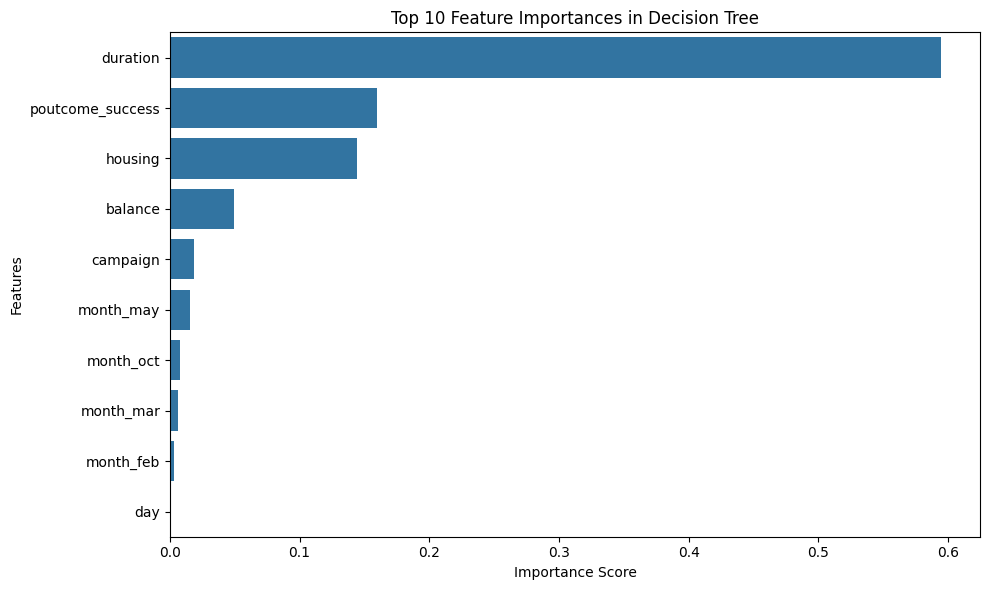

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



feature_importances = pd.Series(dt_model.feature_importances_, index=X_train_sm.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Print top features
print("🔍 Top 10 Important Features:")
print(feature_importances.head(10))

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index)
plt.title("Top 10 Feature Importances in Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


Neural Network Implementation (using TensorFlow/Keras)

In [65]:
# Import TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [66]:
# Use SMOTE-resampled training data for training the NN
# already have:
# X_train_sm, y_train_sm for training (balanced)
# X_test, y_test for testing (original distribution)

In [67]:
# Build the Neural Network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_sm.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

In [68]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

# Set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model without class weights
history = model.fit(
    X_train_sm, y_train_sm,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7605 - loss: 0.4769 - val_accuracy: 0.8607 - val_loss: 0.4511
Epoch 2/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8375 - loss: 0.3617 - val_accuracy: 0.8557 - val_loss: 0.4711
Epoch 3/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8475 - loss: 0.3461 - val_accuracy: 0.8723 - val_loss: 0.4324
Epoch 4/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8539 - loss: 0.3373 - val_accuracy: 0.8852 - val_loss: 0.3960
Epoch 5/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8572 - loss: 0.3274 - val_accuracy: 0.8852 - val_loss: 0.3943
Epoch 6/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8616 - loss: 0.3208 - val_accuracy: 0.9011 - val_loss: 0.3554
Epoch 7/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8604 - loss: 0.3198 - val_accuracy: 0.8999 - val_loss: 0.3654
Epoch 8/100
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8628 - loss: 

In [70]:
# Predict on test data
y_pred_prob_nn = model.predict(X_test).ravel()
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 Neural Network Accuracy: 0.8498

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.43      0.82      0.56      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.84      0.73      9043
weighted avg       0.91      0.85      0.87      9043



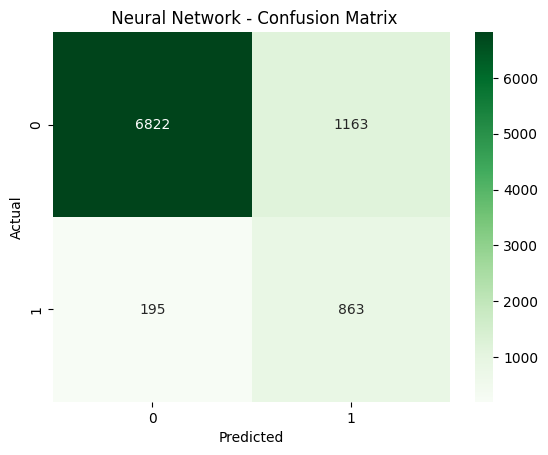

In [71]:
# Accuracy
nn_accuracy = accuracy_score(y_test, y_pred_nn)
print(f" Neural Network Accuracy: {nn_accuracy:.4f}")

# Classification Report
print("\n Classification Report:")
print(classification_report(y_test, y_pred_nn))

# 9. Confusion matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Greens')
plt.title(" Neural Network - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [72]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob_nn)
print(f" ROC-AUC Score: {roc_auc:.4f}")

 ROC-AUC Score: 0.9103


In [73]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# As dataframe
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
report_nn = classification_report(y_test, y_pred_nn, output_dict=True)

df_report_dt = pd.DataFrame(report_dt).transpose()
df_report_nn = pd.DataFrame(report_nn).transpose()

print("\n Decision Tree Classification Report:")
display(df_report_dt.round(2))

print("\n Neural Network Classification Report:")
display(df_report_nn.round(2))



 Decision Tree Classification Report:


,precision,recall,f1-score,support
0,0.97,0.79,0.87,7985.00
1,0.33,0.81,0.47,1058.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.65,0.80,0.67,9043.00
weighted avg,0.90,0.79,0.82,9043.00



 Neural Network Classification Report:


,precision,recall,f1-score,support
0,0.97,0.85,0.91,7985.00
1,0.43,0.82,0.56,1058.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.70,0.84,0.73,9043.00
weighted avg,0.91,0.85,0.87,9043.00
